### Show Input Sample
Our network receives a video of blinking emitters as input. Each video contains a pre-determined number of frames and the number of emitters we observe is bounded by another pre-determined parameter - maxSources.

In [154]:
# Setup
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
import h5py
import os
import pickle

import dataset_NEWtf

def loadDataObj(path, set_str):
    with open(os.path.join(path, set_str + '.obj'), 'rb') as dataFile:
        dataObj = pickle.load(dataFile)
    return dataObj

def pickSample(dataObj):
    numSamples = dataObj.labels.shape[0]
    randIDx = np.random.randint(numSamples)
    featureSample = dataObj.features[randIDx,:,:,:]
    labelSample = dataObj.labels[randIDx,:,:,:]
    return featureSample, labelSample

def showSample(input_sample):
    numFrames = input_sample.shape[-1]
    fig = plt.figure()
    im = plt.imshow(input_sample[:,:,0])

    def update(i):
        img = input_sample[:,:,i]
        im.set_data(img)
        return im
        
    ani = animation.FuncAnimation(fig, update, frames=numFrames, repeat=False)  
    display(HTML(ani.to_html5_video()))
    
def printSampleParams(input_sample):
    imgSize, _, numFrames = np.shape(input_sample[0])
    maxSources = np.shape(input_sample[1])[-1]
    print('Image Size:', imgSize)
    print('Number of Frames:', numFrames)
    print('Max Sources:', maxSources)


In [156]:
path = os.path.join('..', 'DataSimulation', 'Dataset_im64_f8_s2')
testObj = loadDataObj(path, 'test')
sample_x, sample_y = pickSample(testObj)
printSampleParams((sample_x, sample_y))

Image Size: 64
Number of Frames: 8
Max Sources: 2


In [ ]:
showSample(sample_x)

### Validation Sample Output 
After training the model with 80% of the entire training set (holding out the rest for validation), we first show the estimated sources versus the ground truth. The input is the video showed above and it is randomly selected from the validation set.  

In [38]:
import tensorflow as tf

def evalPredictions(input_tensor):
    """Evaluates the predicted output of the model. 
       First, imports the graph and then restores the model variables from the latest checkpoint.
    Args:
        input_tensor: Tensor of shape [batchSize, imgSize, imgSize, numFrames]  
    """
    tf.reset_default_graph()  
    # First- import the saved graph
    imported_graph = tf.train.import_meta_graph(os.path.join('..', 'checkpoints', 'ckpt_im64_f8_s2',
                                                             'im64_f8_s2_2018-05-11_1356.meta'))
    graph = tf.get_default_graph()
    x = graph.get_tensor_by_name('x:0')
    keep_prob = graph.get_tensor_by_name('dropout/Placeholder:0') #TODO: change to friendly variable names
    y_conv = graph.get_tensor_by_name('reshape_y/Reshape:0')
    with tf.Session() as sess:
        # Second- import the model variables
        imported_graph.restore(sess, tf.train.latest_checkpoint(os.path.join('..', 'checkpoints', 'ckpt_im64_f8_s2')))
        feed_dict = {x: input_tensor, keep_prob: 0}
        y_pred = sess.run(y_conv, feed_dict = feed_dict)
    return y_pred

def removeNons(y_pred, y_labels):
    """Removes the zero labels and corresponding predictions.
    Args:
        y_pred  : network output 
        y_labels: labels matrix
    """
    maxSources = y_labels.shape[-1]
    idxs = []
    for i in range(maxSources):
        if (y_labels[:,:,i] == np.zeros(y_labels[:,:,i].shape)).all():
            continue
        idxs = np.append(idxs, i).astype(int)
    y_tot = np.append(y_labels[:,:,idxs], y_pred[:,:,idxs], axis=2)
    return y_tot
    
def showPredictions(y_pred, y_labels):
        y_preds = y_pred[0,:,:,:]
        y_tot = removeNons(y_preds, y_labels)
        numSources = y_labels.shape[-1]
        fig, axes = plt.subplots(2, numSources)
        for i, ax in enumerate(axes.flat):
            ax.imshow(y_tot[:,:,i], aspect='auto')
            ax.set_xticks([])
            ax.set_yticks([])
        plt.show()

INFO:tensorflow:Restoring parameters from C:\Users\orrav\Documents\Technion\Alex_Orr_Project\NNflow\checkpoints\ckpt_im64_f8_s2\im64_f8_s2_2018-05-11_1356


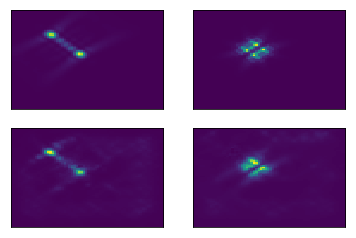

In [39]:
input_tensor = np.expand_dims(sample_x, axis=0)
# Predict model output for input_tensor as input
y_pred = evalPredictions(input_tensor)
# Show GroundTruth Vs. Estimated
showPredictions(y_pred, sample_y)

### Evaluate Best Model on Test-Set

In [114]:
from tensorflow.python.keras.models import load_model
from tensorflow.python.keras import backend as K
from Models_keras import NCC
import tensorflow as tf

path_best_model = 'best_model.keras'

model = load_model(path_best_model, custom_objects={'NCC': NCC})
result = model.evaluate(x=testObj.features,
                        y=testObj.labels)

1000/1000 [==============================] - 26s 26ms/step
NCC: 0.9950535750389099


Evaluating the performance of our best model on the entire test set. The accuracy metric used is Normalized Cross Correlation (NCC). The highest score (best possible accuracy) is 1 and lowest is 0.

In [117]:
print("{0}: {1:.4}".format(model.metrics_names[1], result[1]))

NCC: 0.9951


### Predict on New Data (Test Sample)
We use the previously displayed test sample as input, and predict the network output. We remove zero-valued labels and their corresponding match in order to get the actual number of sources instead of the maximum number of sources. 

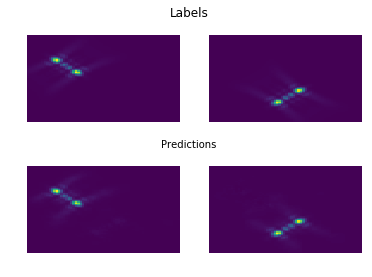

In [163]:
import numpy as np

def removeNons(y_pred, y_labels):
    """Removes the zero labels and corresponding predictions.
    Args:
        y_pred  : network output 
        y_labels: labels matrix
    """
    maxSources = y_labels.shape[-1]
    idxs = []
    for i in range(maxSources):
        if (y_labels[:,:,i] == np.zeros(y_labels[:,:,i].shape)).all():
            continue
        idxs = np.append(idxs, i).astype(int)
    y_tot = np.append(y_labels[:,:,idxs], y_pred[:,:,idxs], axis=2)
    return y_tot
    
def showPredictions(y_pred, y_labels):
        # Truncate dimensions
        y_preds = y_pred[0,:,:,:]
        y_tot = removeNons(y_preds, y_labels)
        numSources = int(y_tot.shape[-1]/2)
        fig, axes = plt.subplots(2, numSources)
        plt.suptitle('Labels')
        plt.subplots_adjust(hspace=0.5)
        plt.figtext(0.5, 0.5, 'Predictions', ha='center', va='center')
        for i, ax in enumerate(axes.flat):
            ax.imshow(y_tot[:,:,i], aspect='auto')
            ax.axis('off')
        plt.show()

sample_xe = np.expand_dims(sample_x, axis=0)
y_pred = model.predict(x = sample_xe)
showPredictions(y_pred, sample_y)